In [148]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
print(cv2.__version__)

3.4.2


In [151]:
cnt = 0

[array([[ 9.95871516e-01, -2.34984050e-03,  1.36897862e+00],
       [ 7.00681195e-05,  9.92358396e-01,  4.87304249e+02],
       [-2.06762854e-06, -5.53878072e-06,  1.00000000e+00]])] 1


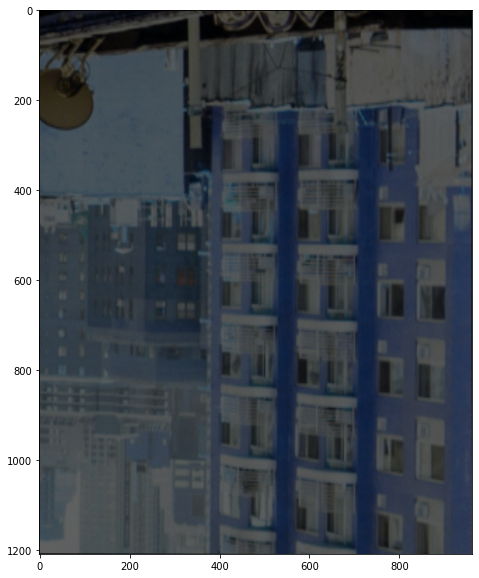

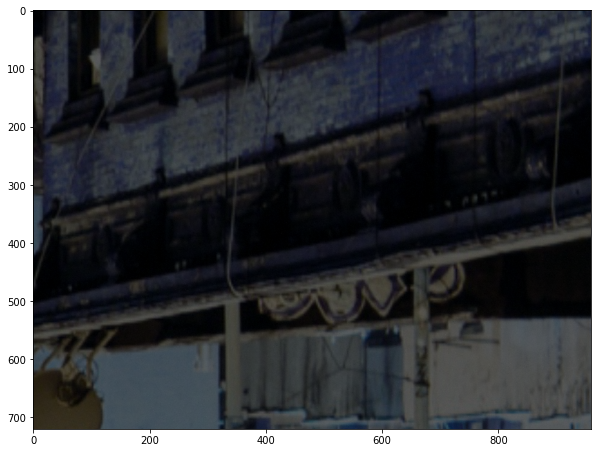

In [158]:
# For this part the stitching were the continuously stitched image isn't warped 
# works better than the stitching were the stitching is warped


try:
    homo3 = "homography_list_3"
    hml3 = open(homo3, 'rb')  # Open the file
    hm_list = pickle.load(hml3)  # Assign the recreated object
    print(hm_list,len(hm_list))
except FileNotFoundError as e:
    print(e,"homo3")

#using one of every stereo image pair...hence imgs..1,3,5,7,...etc
#im1 changing...is the main stitch ....im2 is the new image being added
im1 = cv2.imread("factory_imgs/camera1-3-5.png")
im2 = cv2.imread("factory_imgs/camera5.png")

plt.figure(figsize=(10,10))
plt.imshow(im1)
plt.figure(figsize=(10,10))
plt.imshow(im2)

K1 = np.array([[269.7977676690669, 0.0, 539.4244485376425],  
             [0.0, 269.7474290400939, 359.5466822104538],
             [0.0, 0.0, 1.0]])
cnt +=1

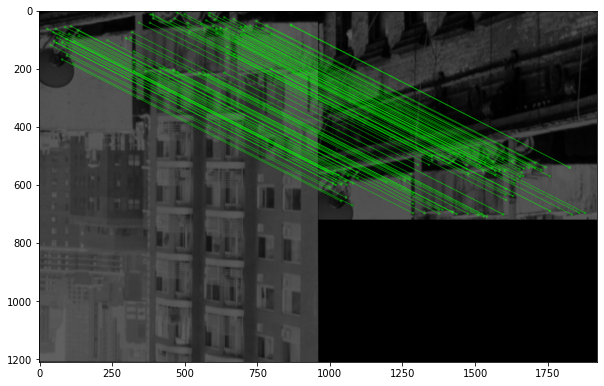

In [159]:
gray_img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
#
# # print("start")
# # Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
a = gray_img1
b = gray_img2
#
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(a, None)
kp2, des2 = sift.detectAndCompute(b, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10
ransac_thresh = 0.5
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    E, mask = cv2.findEssentialMat(src_pts, dst_pts, K1, cv2.RANSAC, ransac_thresh, 1,
                                   None)  # apply ransac and get E matrix
    _, R, T, mask = cv2.recoverPose(E, src_pts, dst_pts, cameraMatrix=K1,
                                    mask=mask)  # get rotation and translation
    matchesMask = mask.ravel().tolist()

    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 6.0)
    matchesMask = mask.ravel().tolist()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

fimg = cv2.drawMatches(a, kp1, b, kp2, good, None, **draw_params)
plt.figure(figsize=(10,10))
plt.imshow(fimg)

In [160]:
passed,translated_H,stitched,b_x,b_y = 0,0,0,0,0

# cameras = [dist_camera2]
# imga = dist_camera1

# cameras = [im2]
# imga = im1
# print("starting")
# homography = h_lateral
# for i, imgb in enumerate(cameras):
imga = im1.copy()
imgb = im2.copy()
# imga, imgb = im_check(im1, im2) #match image sizes

gray_img1 = cv2.cvtColor(imga, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(imgb, cv2.COLOR_BGR2GRAY)

a = gray_img1
b = gray_img2

# center of source image
center_pt = [a.shape[1] // 2, a.shape[0] // 2, 1]

# find where center of source image will be after warping without comepensating for any offset
warped_pt = np.dot(homography, center_pt)
warped_pt = [x / warped_pt[2] for x in warped_pt]
# print("passing")
inc = 3
cond = True
while cond:
    # warping output image size # center of warping output image
    stitched_frame_size = tuple(int(inc * x) for x in a.shape)
    w, h = stitched_frame_size
    im_copy = np.zeros((w, h, 3), np.uint8)

    # calculate offset for translation of warped image  ...find the offset to the center of the blank image
    x_offset = stitched_frame_size[0] / 2 - warped_pt[0]
    y_offset = stitched_frame_size[1] / 2 - warped_pt[1]

    # translation matrix
    Trans = np.array([[1, 0, x_offset], [0, 1, y_offset], [0, 0, 1]])
    # translate tomography matrix
    translated_H = np.dot(Trans, homography)

    # get the location to add the other stitched image
    b_x = int(x_offset)
    b_y = int(y_offset)

    hold = False
    try:
        hold = False
        stitched = cv2.warpPerspective(imga, translated_H, stitched_frame_size)
#         stitched = cv2.warpPerspective(imga, homography, stitched_frame_size)
#         stitched[b_y:b.shape[0]+b_y, b_x:b.shape[1]+b_x] = imgb  #on the first image match use this
        if cnt == 1:
            stitched[b_y:b.shape[0]+b_y, b_x:b.shape[1]+b_x] = imgb  #on the first image match use this
        else:
            im_copy[b_y:b.shape[0] + b_y, b_x:b.shape[1] + b_x] = imgb  # check sizing using blank image to get the best image size
    except ValueError as e:
        inc += 3
        hold = True
    if not hold:
        break

# plt.figure(figsize=(10,10))
# plt.imshow(stitched)
# plt.figure(figsize=(10,10))
# plt.imshow(imgb)
# plt.figure(figsize=(15,15))
# plt.imshow(im3)
# plt.figure(figsize=(10,10))
# plt.imshow(im4)

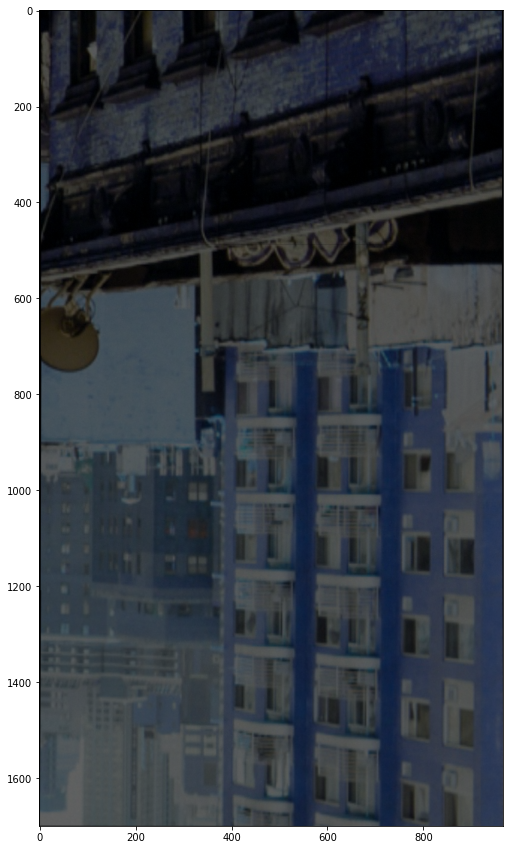

In [161]:
# if passed:
hold_img = stitched[b_y:b.shape[0] + b_y, b_x:b.shape[1] + b_x]  # create roi
# Now create a mask of logo and create its inverse mask also
new2_gray = cv2.cvtColor(hold_img, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(new2_gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(hold_img, hold_img, mask=mask)

# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(imgb, imgb, mask=mask_inv)
# Put logo in ROI and modify the main image

dst = cv2.add(img1_bg, img2_fg)
stitched[b_y:b.shape[0] + b_y, b_x:b.shape[1] + b_x] = dst

    # cropping function
    # 2d ..x,y format... clockwise..
a_sizes = [[0, 0, 1],  # this should be the warped image
           [a.shape[1], 0, 1],
           [a.shape[1], a.shape[0], 1],
           [0, a.shape[0], 1]]

b_sizes = [[b_x, b_y],  # non warped image
           [b.shape[1] + b_x, b_y],
           [b.shape[1] + b_x, b.shape[0] + b_y],
           [b_x, b.shape[0] + b_y]]

new_pts_warped = []
for pt in a_sizes:  # find the new warped location points of the warped image
    warped_pt = np.dot(translated_H, pt)
    warped_pt = [x / warped_pt[2] for x in warped_pt]
    new_pts_warped.append(warped_pt)

new_pts_warped = np.array(new_pts_warped)[0:, 0:2]  # get the first 2 columns since the third column is just ones
non_warped = np.array(b_sizes)

all_pts = np.concatenate((new_pts_warped, non_warped))
x = int(min(all_pts[:, 0]))  # get the min x
xw = int(max(all_pts[:, 0]))  # get the max x
y = int(min(all_pts[:, 1]))  # get the min y
yh = int(max(all_pts[:, 1]))  # get the max y
stitched = stitched[y:yh, x:xw]  # crop image
# imga = stitched
plt.figure(figsize=(15,15))
plt.imshow(stitched)

In [162]:
# hm_list = []              #doing a pickle save for python 2 and 3 because jupyter uses 2 and ROS uses 3
hm_list.append(homography)

val2 = "homography_list_2"
val3 = "homography_list_3"
hm2 = open(val2, "wb")  # Open the file
hm3 = open(val3, "wb")  # Open the fil
pickle.dump(hm_list, hm2, protocol=2)  # Dump the dictionary bok, the first parameter into the file object w.
pickle.dump(hm_list, hm3)
hm2.close()
hm3.close()
print("done")

done


In [163]:
cv2.imwrite("factory_imgs/camera1-3-5.png",stitched)     #save the image to be used for the next consecutive img stitch

True

In [52]:
print(np.arange(4))

[0 1 2 3]
